In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform

In [181]:
def PlaceField(x,y,x_c,y_c,peak_act=1,pf_sigma=10): 
    x_off = (x-x_c)**2
    y_off = (y-y_c)**2
    pf_act = peak_act*np.exp(-(x_off+y_off)/(2*pf_sigma**2))
    return pf_act


def BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1):
    X_Grid, Y_Grid = np.meshgrid(np.arange(0,L,Samp_Dens),np.arange(0,L,Samp_Dens)) 
    
    CA3_X = np.linspace(0,L,int(L/CA3_Dens)+1) 
    CA3_X = (CA3_X[0:-1]+CA3_X[1:])/2
    
    X_Pf , Y_Pf = np.meshgrid(CA3_X,CA3_X)
    
    return X_Grid, Y_Grid, X_Pf, Y_Pf, X_Pf.size

def Connections_Init(N_CA3,N_CA1):
    Conn = np.random.rand(N_CA3,N_CA1)
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    return Conn

def Compute_Sparsity(Vec):
    sp = (np.mean(Vec))**2/np.mean(Vec**2)
    return sp


def Normalize_Activity(Act,m_trgt=1,s_trgt=0.1):
    s = 1
    thr = np.mean(Act)
    thr_u = np.max(Act)
    thr_d = np.min(Act)
    cc = 0
    while np.abs(s-s_trgt)>0.01:
        Act_thr = Act - thr
        Act_thr[Act_thr<0] = 0

        s = Compute_Sparsity(Act_thr)
        dec_s = np.sign(s-s_trgt)
        if dec_s==1:
            thr_d,thr,thr_u = [thr, (thr_u+thr_d)/2, thr_u]
        else:
            thr_d,thr,thr_u = [thr_d, (thr_u+thr_d)/2, thr]
        cc = cc + 1
        if(cc>1000):
            break
            
    Act_thr = Act_thr/np.mean(Act_thr)*m_trgt
    return Act_thr

def Compute_Plasticity(Pre,Post,eta=0.001):
    dw = Pre @ ((Post-np.mean(Post,axis=0)).T)
    dw = dw * eta
    return dw

def Apply_Plasticity(Conn,dw_tot):
    Conn += dw_tot
    Conn[Conn<0] = 0
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    Conn[np.isnan(Conn)] = 0
    return Conn


/Users/federico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


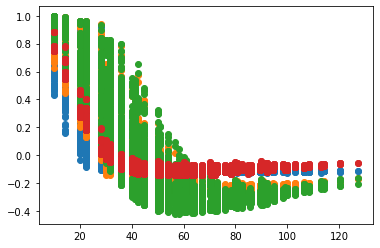

In [188]:
eta_l = 0.0001 # LEARNING RATE
n_rounds = 5 # AMOUNT OF LEARNING
for spars in [0.1,0.2,0.3]:
    
    # TRAINING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)

    for l_round in range(n_rounds):
        dw_tot = 0
        for zz in range(XY_Coor.shape[0]):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            CA1_Act = Act_XY@Conn


            CA1_Time = Normalize_Activity(CA1_Act,1,s_trgt=spars)

            Pre = Act_XY[:,np.newaxis]

            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)

    # TESTING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3


    CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
    for zz in range(XY_Coor.shape[0]):
        Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
        CA1_Act = Act_XY@Conn


        CA1_Out[zz,:] = Normalize_Activity(CA1_Act,1,s_trgt=spars)


    CA1_DD = 1 - pdist(CA1_Out,metric='correlation')
    plt.scatter(XY_DD,CA1_DD)

CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')
plt.scatter(XY_DD,CA3_DD)

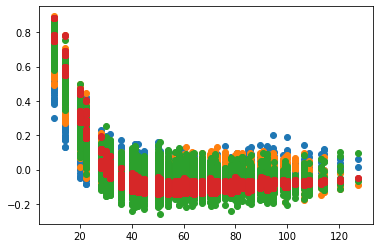

In [191]:
eta_l = 0.0001
n_rounds = 0 # NO LEARNING
for spars in [0.1,0.2,0.3]:
    
    # TRAINING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)

    for l_round in range(n_rounds):
        dw_tot = 0
        for zz in range(XY_Coor.shape[0]):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            CA1_Act = Act_XY@Conn


            CA1_Time = Normalize_Activity(CA1_Act,1,s_trgt=spars)

            Pre = Act_XY[:,np.newaxis]

            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)

    # TESTING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3


    CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
    for zz in range(XY_Coor.shape[0]):
        Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
        CA1_Act = Act_XY@Conn


        CA1_Out[zz,:] = Normalize_Activity(CA1_Act,1,s_trgt=spars)


    CA1_DD = 1 - pdist(CA1_Out,metric='correlation')
    plt.scatter(XY_DD,CA1_DD)

CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')
plt.scatter(XY_DD,CA3_DD)